In [1]:
!pip install xgboost shap openpyxl scikit-learn seaborn matplotlib pandas --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load the dataset
df = pd.read_csv('Water Quality Prediction Dataset.csv', sep=';')
df

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.50,0.057,154.00,0.454,289.50
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.75,0.034,352.00,0.090,1792.00
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.80,0.173,416.00,0.200,2509.00
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.13,0.099,275.20,0.377,1264.00
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.00,0.065,281.60,0.134,1462.00
...,...,...,...,...,...,...,...,...,...,...,...
2856,22,06.10.2020,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,77.85
2857,22,27.10.2020,0.000,1.52,0.5,11.26,0.56,0.031,147.20,0.634,71.95
2858,22,03.12.2020,0.034,0.29,0.8,11.09,2.58,0.042,209.92,0.484,61.17
2859,22,12.01.2021,0.000,2.10,0.0,14.31,3.94,0.034,121.60,0.424,63.49


In [5]:
df.info() # dataset info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2861 non-null   int64  
 1   date       2861 non-null   object 
 2   NH4        2858 non-null   float64
 3   BSK5       2860 non-null   float64
 4   Suspended  2845 non-null   float64
 5   O2         2858 non-null   float64
 6   NO3        2860 non-null   float64
 7   NO2        2858 non-null   float64
 8   SO4        2812 non-null   float64
 9   PO4        2833 non-null   float64
 10  CL         2812 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 246.0+ KB


In [6]:
# rows and cols
df.shape

(2861, 11)

In [7]:
# Statistics of the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2861.0,12.397064,6.084226,1.00,8.0000,14.000,16.00000,22.000
NH4,2858.0,0.758734,2.486247,0.00,0.0800,0.220,0.50000,39.427
BSK5,2860.0,4.316182,2.973997,0.00,2.1600,3.800,5.80000,50.900
Suspended,2845.0,12.931905,16.543097,0.00,6.0000,10.000,15.00000,595.000
O2,2858.0,9.508902,4.428260,0.00,7.0925,8.995,11.52000,90.000
NO3,2860.0,4.316846,6.881188,0.00,1.3900,2.800,5.58250,133.400
NO2,2858.0,0.246128,2.182777,0.00,0.0300,0.059,0.12575,109.000
SO4,2812.0,59.362313,96.582641,0.00,27.0525,37.800,64.64000,3573.400
PO4,2833.0,0.418626,0.771326,0.00,0.1300,0.270,0.47000,13.879
CL,2812.0,93.731991,394.512184,0.02,26.8000,33.900,45.60750,5615.280


In [8]:
# Missing values
df.isnull().sum()

,0
id,0
date,0
NH4,3
BSK5,1
Suspended,16
O2,3
NO3,1
NO2,3
SO4,49
PO4,28


In [9]:
# date is in object - convert to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,2000-02-17,0.330,2.77,12.0,12.30,9.50,0.057,154.00,0.454,289.50
1,1,2000-05-11,0.044,3.00,51.6,14.61,17.75,0.034,352.00,0.090,1792.00
2,1,2000-09-11,0.032,2.10,24.5,9.87,13.80,0.173,416.00,0.200,2509.00
3,1,2000-12-13,0.170,2.23,35.6,12.40,17.13,0.099,275.20,0.377,1264.00
4,1,2001-03-02,0.000,3.03,48.8,14.69,10.00,0.065,281.60,0.134,1462.00
...,...,...,...,...,...,...,...,...,...,...,...
2856,22,2020-10-06,0.046,2.69,3.6,8.28,3.80,0.038,160.00,0.726,77.85
2857,22,2020-10-27,0.000,1.52,0.5,11.26,0.56,0.031,147.20,0.634,71.95
2858,22,2020-12-03,0.034,0.29,0.8,11.09,2.58,0.042,209.92,0.484,61.17
2859,22,2021-01-12,0.000,2.10,0.0,14.31,3.94,0.034,121.60,0.424,63.49


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         2861 non-null   int64         
 1   date       2861 non-null   datetime64[ns]
 2   NH4        2858 non-null   float64       
 3   BSK5       2860 non-null   float64       
 4   Suspended  2845 non-null   float64       
 5   O2         2858 non-null   float64       
 6   NO3        2860 non-null   float64       
 7   NO2        2858 non-null   float64       
 8   SO4        2812 non-null   float64       
 9   PO4        2833 non-null   float64       
 10  CL         2812 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 246.0 KB


In [11]:
df = df.sort_values(by=['id', 'date'])
df.head()

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,2000-02-17,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5
1,1,2000-05-11,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0
2,1,2000-09-11,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0
3,1,2000-12-13,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0
4,1,2001-03-02,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0


In [12]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [13]:
df.head()

,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL,year,month
0,1,2000-02-17,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5,2000,2
1,1,2000-05-11,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0,2000,5
2,1,2000-09-11,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0,2000,9
3,1,2000-12-13,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0,2000,12
4,1,2001-03-02,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0,2001,3


In [14]:
df.columns

Index(['id', 'date', 'NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4',
       'PO4', 'CL', 'year', 'month'],
      dtype='object')

In [15]:
feature_cols = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']
df_raw = df.copy()

In [16]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
df[feature_cols] = imputer.fit_transform(df[feature_cols])

# Log transform for skew > 1
skewed = df[feature_cols].skew()
for col in skewed[skewed > 1].index:
    df[col] = np.log1p(df[col])

# Standardize
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[feature_cols]), columns=feature_cols)
df_scaled['month'] = df['month']
df_scaled['year'] = df['year']

In [17]:
# Standard & ideal limits
S_i = {'NH4': 0.5, 'BSK5': 3, 'Suspended': 20, 'O2': 14, 'NO3': 45, 'NO2': 3, 'SO4': 400, 'PO4': 0.1, 'CL': 250}
V_i = {'NH4': 0, 'BSK5': 0, 'Suspended': 0, 'O2': 14, 'NO3': 0, 'NO2': 0, 'SO4': 0, 'PO4': 0, 'CL': 0}

# Imputed raw values (unscaled)
raw_imputed = pd.DataFrame(imputer.transform(df_raw[feature_cols]), columns=feature_cols)

# Weight calculation
W_i = {k: 1/v for k, v in S_i.items()}
total_weight = sum(W_i.values())
W_i = {k: w/total_weight for k, w in W_i.items()}

# WQI function
def calculate_wqi(row):
    score = 0
    for param in feature_cols:
        Va = row[param]
        S, Vi = S_i[param], V_i[param]
        if param == 'O2':
            Q = ((S - Va) / (S - Vi)) * 100
        else:
            Q = ((Va - Vi) / (S - Vi)) * 100
        Q = np.clip(Q, 0, 100)
        score += Q * W_i[param]
    return score

df_scaled['WQI'] = raw_imputed.apply(calculate_wqi, axis=1)

In [18]:
# Classify WQI
bins = [0, 25, 50, 75, 100, np.inf]
labels = ['Excellent', 'Good', 'Poor', 'Very Poor', 'Unsuitable']
df_scaled['WQC'] = pd.cut(df_scaled['WQI'], bins=bins, labels=labels)

In [19]:
# Drop NaNs in label
df_scaled = df_scaled.dropna(subset=['WQC'])

# Prepare features and label
X = df_scaled.drop(columns=['WQI', 'WQC'])
y = df_scaled['WQC']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified split
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False)
grid = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=3, n_jobs=-1)
grid.fit(X_train, y_train_encoded)

best_model = grid.best_estimator_

Best Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.9790209790209791

Classification Report:
               precision    recall  f1-score   support

   Excellent       0.90      0.95      0.93        20
        Good       0.85      0.88      0.87        33
        Poor       0.87      0.89      0.88        38
   Very Poor       1.00      0.99      1.00       481

    accuracy                           0.98       572
   macro avg       0.91      0.93      0.92       572
weighted avg       0.98      0.98      0.98       572



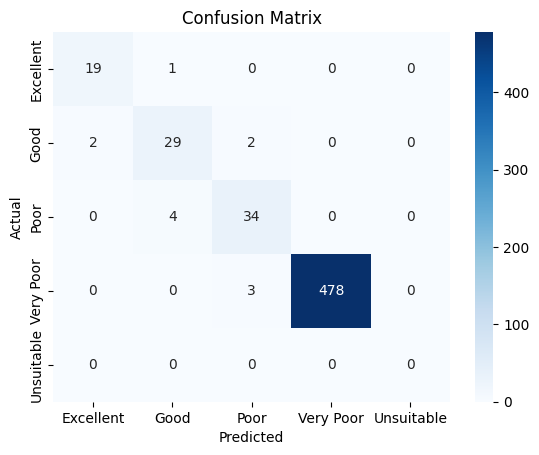

In [21]:
# Predict and decode
y_pred_encoded = best_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
conf = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
sns.heatmap(conf, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

 96%|=================== | 2195/2288 [00:14<00:00]       

Class index mapping:
0 → Excellent
1 → Good
2 → Poor
3 → Very Poor


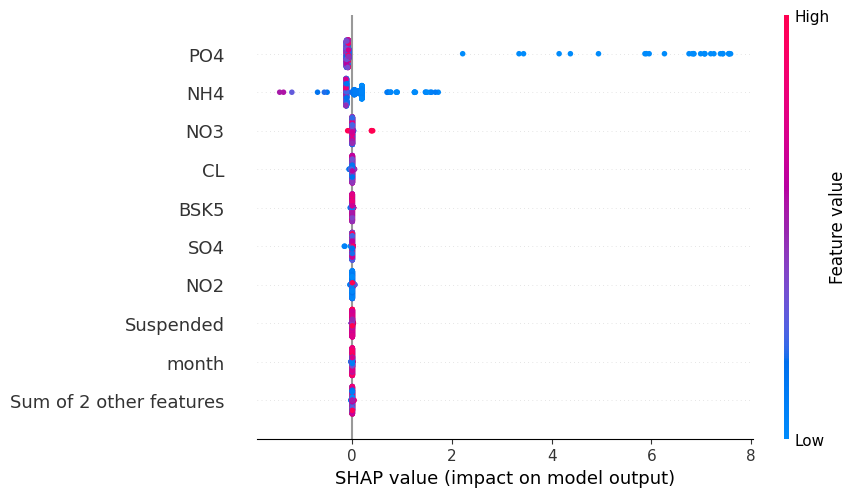

In [23]:
# Step 1: Initialize SHAP Explainer
explainer = shap.Explainer(best_model, X_train)

# Step 2: Compute SHAP values (shape: [n_samples, n_features, n_classes])
shap_values = explainer(X_test)

# Step 3: View class index mapping (for reference)
print("Class index mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} → {label}")

# Step 4: Select class index to visualize (change index to any valid class)
class_index = 0  # e.g., 0 = 'Excellent'

# Step 5: Extract SHAP values for that class
shap_values_class = shap_values[:, :, class_index]

# Step 6: Beeswarm plot for selected class
shap.plots.beeswarm(shap_values_class, max_display=10)